In [193]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np 
import datetime
import osmnx as ox

In [ ]:
# Create a polygon for event venue
from shapely.geometry import Polygon
import geopandas as gpd

lat_point_list = [30.131962, 30.146337, 30.140386, 30.122629]
lon_point_list = [-97.647388, -97.635686, -97.619652, -97.631465]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       
polygon['name']  = 'the Circuit of the Americas'
polygon
# polygon.explore()

In [2]:
# %%time
# df_stops = pd.read_pickle("./data/cuebiq/texas_stops_20221021_20221023.pkl")  
# df_stops['Time'] = df_stops['stop_zoned_datetime'].astype(str).str[0:-6]
# df_stops.drop(['stop_zoned_datetime'], axis=1, inplace=True)
# df_stops['Time'] = pd.to_datetime(df_stops['Time'], errors='coerce')
# print(df_stops.shape[0])
# print(df_stops.cuebiq_id.unique().shape[0])
# df_stops.head(2)

864615
110446
CPU times: user 13.3 s, sys: 715 ms, total: 14 s
Wall time: 14.7 s


In [6]:
# df_stops_need = df_stops[['cuebiq_id','lat','lng','event_date','Time','dwell_time_minutes']]
# df_stops_need['departure_time'] = df_stops_need['Time'] + pd.to_timedelta(df_stops_need['dwell_time_minutes'], unit='m')
# df_stops_need = df_stops_need[['cuebiq_id','lat','lng','departure_time']]

# import geopandas as gpd

# gdf_stops = gpd.GeoDataFrame(
#     df_stops_need,
#     geometry=gpd.points_from_xy(df_stops_need.lng, df_stops_need.lat),
#     crs="EPSG:4326"
# )
# df_stops_need.head()

# Load traj data

In [12]:
df_traj = pd.read_pickle("./data/cuebiq/texas_traj_20221021_20221023.pkl")  
print(df_traj.shape[0])
print(df_traj.cuebiq_id.unique().shape[0])

100424
7512


In [316]:
# df_traj

In [125]:
df_traj_need = df_traj[(df_traj['start_admin1']=='US.TX')&(df_traj['end_admin1']=='US.TX')]
print(df_traj_need.shape[0])

df_traj_need['cuebiq_trip_km'] = df_traj_need.length_meters/1000
df_traj_need['cuebiq_trip_km'].describe()

97667


count   97667.00000
mean    21.85148   
std     78.55275   
min     0.04014    
25%     0.93240    
50%     4.27115    
75%     22.74442   
max     7373.06359 
Name: cuebiq_trip_km, dtype: float64

In [ ]:
# %%time

# G = ox.graph_from_bbox(bbox=(30.584984, 30.039047, -97.389445, -97.996048), network_type='drive') 

# # Add edge travel time (assumes speed limit if not available)
# G = ox.speed.add_edge_speeds(G)  # Adds estimated speeds (km/h)
# G = ox.speed.add_edge_travel_times(G)  # Adds travel time (seconds)

In [ ]:
# graphml_path = "./output/road_network.graphml"  # GraphML format
# gpkg_path = "./output/road_network.gpkg"  # GeoPackage format

# # Save the graph in GraphML format (recommended for reloading in OSMnx)
# ox.save_graphml(G, filepath=graphml_path)

# # Save as GeoPackage (useful for GIS applications)
# ox.save_graph_geopackage(G, filepath=gpkg_path)

# print("Graph saved successfully!")

# Load Austin OSM network 

In [133]:
# Convert to GeoDataFrames (assuming you have 'x' and 'y' columns for coordinates)
nodes_df = pd.read_csv('./output/osm_nodes.csv')
edges_df = pd.read_csv('./output/osm_edges.csv')

nodes_df['geometry'] = gpd.GeoSeries.from_wkt(nodes_df['geometry'])
edges_df['geometry'] = gpd.GeoSeries.from_wkt(edges_df['geometry'])

nodes_gdf = gpd.GeoDataFrame(nodes_df, crs="EPSG:3857", geometry='geometry')
edges_gdf = gpd.GeoDataFrame(edges_df, crs="EPSG:3857", geometry='geometry')

nodes_gdf = nodes_gdf.set_index('osmid')
edges_gdf.set_index(['u', 'v','key'], inplace=True)

G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

In [128]:
# %%time
# # impute speed on all edges missing data
# G = ox.routing.add_edge_speeds(G)
# # calculate travel time (seconds) for all edges
# G = ox.routing.add_edge_travel_times(G)

CPU times: user 3.53 s, sys: 51 ms, total: 3.58 s
Wall time: 3.6 s


In [134]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.routing.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.routing.add_edge_travel_times(G)

In [340]:
# see mean speed/time values by road type
edges = ox.convert.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

In [342]:
edges.head(2)

osmid            name      highway  oneway reversed    length   bearing                                                                                                     geometry  speed_kph  travel_time  ref bridge lanes maxspeed access width tunnel junction
u         v         key                                                                                                                                                                                                                                                                         
151371439 151462706 0    15287110  Heritage Drive  residential  False   False   88.55000  341.40000  LINESTRING (-97.989 30.204, -97.989 30.204)                                                                 35.00000   9.10800       NaN  NaN    NaN   NaN      NaN    NaN   NaN    NaN    
          151371447 0    15277135  Hideaway Cove   residential  False   False   116.61800 60.40000   LINESTRING (-97.989 30.204, -97.988 30.204, -97.988 30.204, -97.988 30.204, -97.988 30.204, -97.988 30.204) 35.00000   11.99499      NaN  NaN    NaN   NaN      NaN    NaN   NaN    NaN

In [135]:
%%time
# Get nearest nodes in the road network
orig_node = ox.distance.nearest_nodes(G, df_traj_need.start_lng, df_traj_need.start_lat)
dest_node = ox.distance.nearest_nodes(G, df_traj_need.end_lng, df_traj_need.end_lat)

df_traj_need['u'] = orig_node
df_traj_need['v'] = dest_node

CPU times: user 423 ms, sys: 0 ns, total: 423 ms
Wall time: 420 ms


In [148]:
# import multiprocessing as mp
# mp.cpu_count()

28

In [162]:
%%time
# Compute shortest travel time (in seconds), # takes 25 min
print(datetime.datetime.now(), 'Computing shortest path weighted by travel time...')
print('total routes: ',len(orig_node))
routes = ox.routing.shortest_path(G, orig_node, dest_node, weight="travel_time",cpus=1)

97667
CPU times: user 25min 24s, sys: 111 ms, total: 25min 24s
Wall time: 25min 24s


In [199]:
%%time
print(datetime.datetime.now(), 'Computing travel time and trip distance...')
print('total routes: ',len(routes))

trip_dist_list, trip_duration_list = [], []
i = 0
for r in routes:
    if i%10000==0:print(i,'/',len(routes))
    if r == None or len(r) <= 1:
        trip_dist_list.append(0)
        trip_duration_list.append(0)
    else: 
        df_one_shortest_path = ox.routing.route_to_gdf(G, r, weight='travel_time')
        v_trip_distance = df_one_shortest_path["length"].sum()/1000
        v_trip_duration = df_one_shortest_path["travel_time"].sum()/60
        trip_dist_list.append(v_trip_distance)
        trip_duration_list.append(v_trip_duration)
    i+=1

2025-01-31 13:59:03.410584 Computing travel time and trip distance...
total routes:  97667
0 / 97667
10000 / 97667
20000 / 97667
30000 / 97667
40000 / 97667
50000 / 97667
60000 / 97667
70000 / 97667
80000 / 97667
90000 / 97667
CPU times: user 7min 26s, sys: 221 ms, total: 7min 26s
Wall time: 7min 26s


In [203]:
df_traj_need['osm_trip_km'] = trip_dist_list
df_traj_need['osm_travel_time_min'] = trip_duration_list

# Check data

In [338]:
df_onetrj = df_traj[(df_traj['cuebiq_id']==4915738899)&(df_traj['number_of_points']==108)]
df_onetrj['trajectory_wkt'] = gpd.GeoSeries.from_wkt(df_onetrj['trajectory_wkt'])
gdf_onetrj = gpd.GeoDataFrame(df_onetrj,crs="EPSG:4326", geometry='trajectory_wkt')
print(gdf_onetrj.end_lat, gdf_onetrj.end_lng) #30.52615,-97.81035
print(gdf_onetrj.start_lat, gdf_onetrj.start_lng) #29.73033, -98.07869
# gdf_onetrj.explore() start_lat start_lng

261   30.52615
Name: end_lat, dtype: float64 261   -97.81035
Name: end_lng, dtype: float64
261   29.73033
Name: start_lat, dtype: float64 261   -98.07869
Name: start_lng, dtype: float64


In [268]:
# # df_traj_need.head(2)
df_traj_need = df_traj_need.rename(columns={"duration_minutes":"cuebiq_travel_time_min"})
df_traj_need['start_zoned_datetime'] = pd.to_datetime(df_traj_need['start_zoned_datetime'], utc=True)
# Extract hour
df_traj_need['hour'] = df_traj_need['start_zoned_datetime'].dt.hour

In [299]:
df_traj_need2 = df_traj_need[['cuebiq_id', 'event_date','hour','number_of_points','cuebiq_trip_km', 'cuebiq_travel_time_min', 'osm_trip_km', 'osm_travel_time_min']]
df_traj_need2.to_csv('./output/texas_traj_20221021_20221023_with_OSMtrip.csv',index=False)

In [305]:
df_traj_need_with_diff = process_df(df_traj_need2)
df_traj_need_with_diff = df_traj_need_with_diff[df_traj_need_with_diff['cuebiq_trip_km']<200]
print(df_traj_need_with_diff.shape[0])
df_traj_need_with_diff = df_traj_need_with_diff[df_traj_need_with_diff['number_of_points']>2]
print(df_traj_need_with_diff.shape[0])

72047
72047
70653
43291


In [310]:
df_traj_need_with_diff['speed_m_per_s'] = (df_traj_need_with_diff['cuebiq_trip_km']*1000) / (df_traj_need_with_diff['cuebiq_travel_time_min']*60) 
df_traj_need_with_diff = df_traj_need_with_diff[(df_traj_need_with_diff['speed_m_per_s']>10)&(df_traj_need_with_diff['speed_m_per_s']<30)]
print(df_traj_need_with_diff.shape[0])

9046


In [314]:
df_traj_need_with_diff[df_traj_need_with_diff['diff_time'] > 100]

,cuebiq_id,event_date,hour,number_of_points,cuebiq_trip_km,cuebiq_travel_time_min,osm_trip_km,osm_travel_time_min,diff_dist,diff_time,speed_m_per_s
178,5461358061,20221023,12,99,140.90349,212.78333,46.54549,33.29639,94.35799,179.48694,11.03654
261,4915738899,20221023,16,108,104.75124,146.25000,66.56022,40.60991,38.19102,105.64009,11.93746
583,6109925317,20221023,20,43,132.81368,154.88333,44.16514,34.83342,88.64853,120.04991,14.29180
648,5926848846,20221023,13,76,86.67817,142.66667,35.85394,41.27746,50.82423,101.38921,10.12595
729,5329847611,20221023,16,80,82.16511,130.83333,0.59785,0.74297,81.56726,130.09036,10.46689
...,...,...,...,...,...,...,...,...,...,...,...
98717,5016392250,20221021,18,88,190.56521,248.83333,46.48314,29.87781,144.08207,218.95553,12.76391
99558,5329929937,20221021,17,137,153.58261,139.11667,44.07781,35.06243,109.50480,104.05424,18.39974
99611,5906786636,20221021,19,130,176.04472,222.63333,69.41657,40.54573,106.62815,182.08760,13.17897
99772,6095795372,20221021,17,129,100.45939,157.03333,36.66929,25.48991,63.79010,131.54342,10.66221


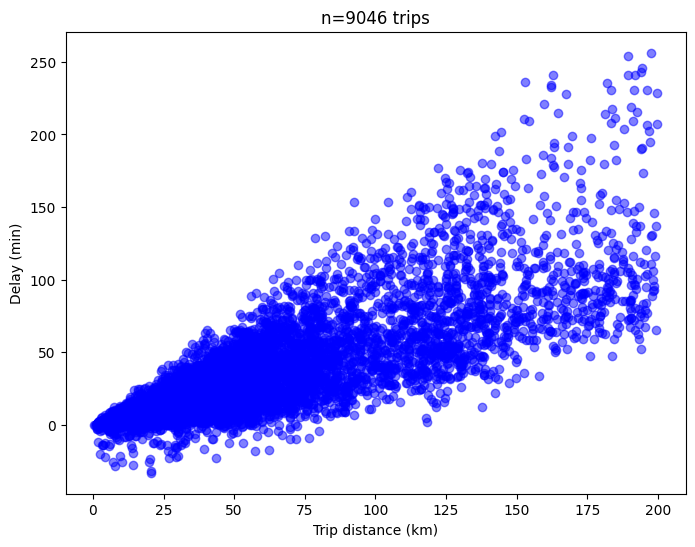

In [311]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_traj_need_with_diff['cuebiq_trip_km'], df_traj_need_with_diff['diff_time'], color='b', alpha=0.5)

# Add labels and title
plt.xlabel('Trip distance (km)')
plt.ylabel('Delay (min)')
plt.title(f'n={df_traj_need_with_diff.shape[0]} trips')

# Show the plot
# plt.grid(True)
plt.show()

# Traffic analysis 

In [269]:
%%time
from shapely.geometry import Point

geometry = [Point(lng, lat) for lat, lng in zip(df_traj_need['start_lat'], df_traj_need['start_lng'])]
gdf_start_points = gpd.GeoDataFrame(df_traj_need, geometry=geometry)
gdf_start_points['overlap_start'] = gdf_start_points.geometry.within(polygon.geometry[0])
gdf_start_points = gdf_start_points[gdf_start_points['overlap_start']==True]
print(gdf_start_points.shape[0])

32212
CPU times: user 1.28 s, sys: 32.2 ms, total: 1.32 s
Wall time: 1.28 s


In [270]:
geometry2 = [Point(lng, lat) for lat, lng in zip(df_traj_need['end_lat'], df_traj_need['end_lng'])]
gdf_end_points = gpd.GeoDataFrame(df_traj_need, geometry=geometry2)
gdf_end_points['overlap_end'] = gdf_end_points.geometry.within(polygon.geometry[0])
gdf_end_points = gdf_end_points[gdf_end_points['overlap_end']==True]
print(gdf_end_points.shape[0])

32664


In [272]:
gdf_end_points_need = gdf_end_points[['cuebiq_id', 'event_date','hour','cuebiq_trip_km', 'cuebiq_travel_time_min', 'osm_trip_km', 'osm_travel_time_min']]
gdf_start_points_need = gdf_start_points[['cuebiq_id', 'event_date','hour','cuebiq_trip_km', 'cuebiq_travel_time_min', 'osm_trip_km', 'osm_travel_time_min']]

In [273]:
def process_df(df):
    df = df[(df['osm_trip_km']!=0)&(df['osm_travel_time_min']!=0)]
    print(df.shape[0])
    df['diff_dist'] = df['cuebiq_trip_km'] - df['osm_trip_km']
    df['diff_time'] = df['cuebiq_travel_time_min'] - df['osm_travel_time_min']
    # df = df[(df['diff_dist']<10)&(df['diff_dist']>-10)]
    print(df.shape[0])
    return df

In [274]:
gdf_end_points_need = process_df(gdf_end_points_need)
gdf_start_points_need = process_df(gdf_start_points_need)

21356
21356
20886
20886


In [276]:
gdf_start_points_need.diff_time.describe()

count   20886.00000
mean    106.65352  
std     110.85455  
min     -25.60843  
25%     33.00867   
50%     70.49187   
75%     139.19946  
max     856.21174  
Name: diff_time, dtype: float64

In [277]:
gdf_end_points_need.diff_time.describe()

count   21356.00000
mean    91.39416   
std     99.62720   
min     -29.64426  
25%     26.44928   
50%     59.52713   
75%     119.50316  
max     1176.15238 
Name: diff_time, dtype: float64

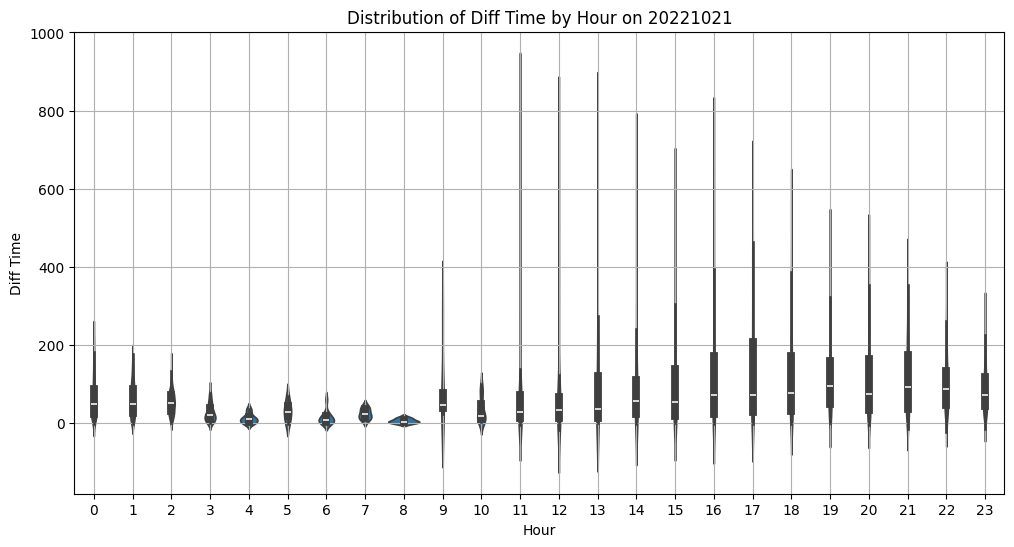

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

# Violin plot for the distribution of diff_time for each hour
plt.figure(figsize=(12, 6))
date  = 20221021
sns.violinplot(x='hour', y='diff_time', data=gdf_start_points_need[gdf_start_points_need['event_date']==date])

# Labels and title
plt.xlabel('Hour')
plt.ylabel('Diff Time')
plt.title(f'Distribution of Diff Time by Hour on {str(date)}')

# Display plot
plt.xticks(range(0, 24))  # Ensure all hours are visible
plt.grid(True)
plt.show()

In [250]:
df_traj_need3 = df_traj_need2[(df_traj_need2['osm_trip_km']!=0)&(df_traj_need2['osm_travel_time_min']!=0)]
print(df_traj_need3.shape[0])
df_traj_need3['diff_dist'] = df_traj_need3['cuebiq_trip_km'] - df_traj_need3['osm_trip_km']
df_traj_need3['diff_time'] = df_traj_need3['cuebiq_travel_time_min'] - df_traj_need3['osm_travel_time_min']

df_traj_need3 = df_traj_need3[(df_traj_need3['diff_dist']<10)&(df_traj_need3['diff_dist']>-10)]
print(df_traj_need3.shape[0])

72047
58946


In [241]:
df_traj_need3['diff_dist'].describe()

count   58946.00000
mean    -0.71899   
std     3.35280    
min     -9.99775   
25%     -2.06356   
50%     -0.39780   
75%     0.38427    
max     9.99893    
Name: diff_dist, dtype: float64

In [242]:
df_traj_need3['diff_time'].describe()

count   58946.00000
mean    63.84311   
std     88.95961   
min     -23.57801  
25%     12.49837   
50%     32.33916   
75%     76.95037   
max     1176.15238 
Name: diff_time, dtype: float64

In [251]:
df_traj_need3['event_date'].unique()

array([20221023, 20221022, 20221021])

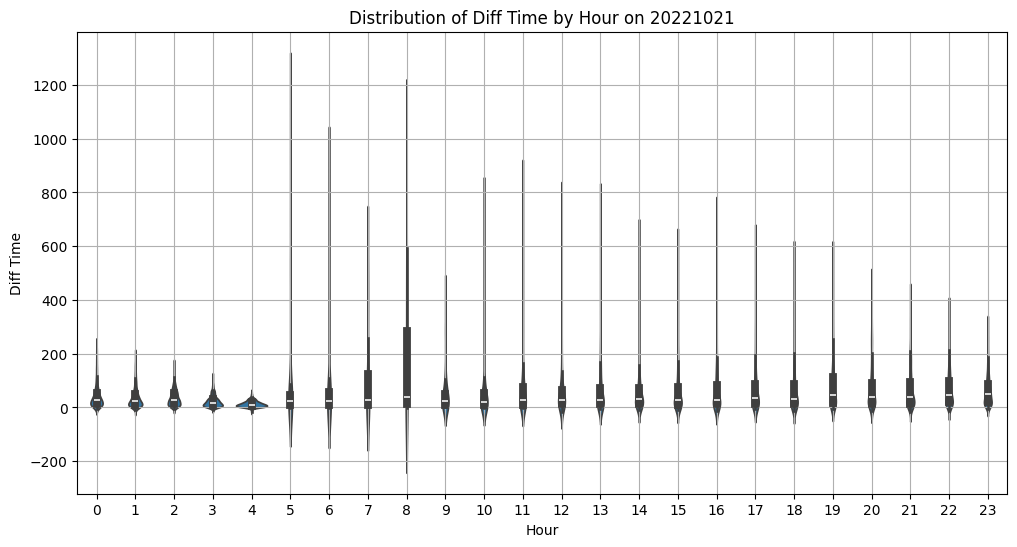

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

# Violin plot for the distribution of diff_time for each hour
plt.figure(figsize=(12, 6))
date  = 20221021
sns.violinplot(x='hour', y='diff_time', data=df_traj_need3[df_traj_need3['event_date']==date])

# Labels and title
plt.xlabel('Hour')
plt.ylabel('Diff Time')
plt.title(f'Distribution of Diff Time by Hour on {str(date)}')

# Display plot
plt.xticks(range(0, 24))  # Ensure all hours are visible
plt.grid(True)
plt.show()

In [73]:
# df_traj_needcol = df_traj_need[['cuebiq_id', 'length_km', 'duration_minutes' ,'trip_distance_km']]
# df_traj_needcol['diff'] = df_traj_needcol['length_km'] - df_traj_needcol['trip_distance_km']
# df_traj_needcol = df_traj_needcol[(df_traj_needcol['diff']<100)&(df_traj_needcol['diff']>-100)]

count   58946.00000
mean    72.69547   
std     91.04409   
min     0.33333    
25%     19.76667   
50%     42.14167   
75%     87.93333   
max     1195.31667 
Name: cuebiq_travel_time_min, dtype: float64
count   58946.00000
mean    8.85236    
std     8.75765    
min     0.00686    
25%     2.15372    
50%     4.73977    
75%     15.44668   
max     86.02074   
Name: osm_travel_time_min, dtype: float64


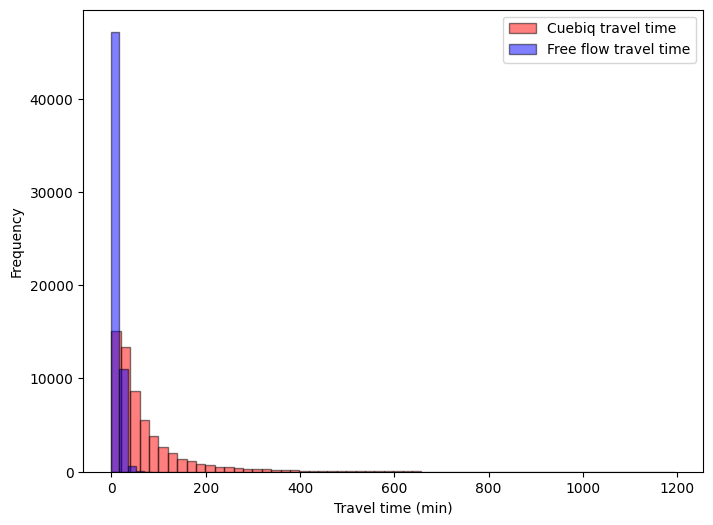

In [257]:
import matplotlib.pyplot as plt

print(df_traj_need3['cuebiq_travel_time_min'].describe())
print(df_traj_need3['osm_travel_time_min'].describe())
# Plot histograms on the same axis
plt.figure(figsize=(8, 6))
plt.hist(df_traj_need3['cuebiq_travel_time_min'], bins=60, alpha=0.5, label='Cuebiq travel time', color='red', edgecolor='black')
plt.hist(df_traj_need3['osm_travel_time_min'], bins=5, alpha=0.5, label='Free flow travel time', color='blue', edgecolor='black')
# Labels and title
plt.xlabel('Travel time (min)')
plt.ylabel('Frequency')
# plt.title('Overlayed Histograms of Trip Distance and Length')
plt.legend()

# Show plot
plt.show()